In [0]:
from google.colab import files

uploaded = files.upload()

!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json

!kaggle datasets download -d vikramtiwari/pix2pix-dataset
!unzip \*.zip  && rm *.zip
!apt-get install tree

Streaming output truncated to the last 5000 lines.
  inflating: edges2shoes/edges2shoes/train/8201_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8202_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8203_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8204_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8205_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8206_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8207_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8208_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8209_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/820_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8210_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8211_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8212_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8213_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8214_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8215_AB.jpg  
  inflating: edges2shoes/edges2shoes/t

In [0]:
!tree -d edges2shoes/

edges2shoes/
└── edges2shoes
    ├── train
    └── val

3 directories


In [0]:
import os,shutil
import pandas as pd
import torch
import numpy as np
from torch import nn
from torchsummary import summary
import torchvision
from torchvision import datasets
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from google.colab import drive
drive.mount('/gdrive')

## Create DataLoaders

In [0]:
class get_dataset(torch.utils.data.Dataset):
  def __init__(self,name='edges2shoes',type_='train',transform=None):
    self.dir_=name+'/'+name+'/'+type_
    self.img_list=sorted(os.listdir(self.dir_))
    self.transform=transform
  def __len__(self):
    return len(self.img_list)
  def __getitem__(self,idx):
    both=plt.imread(self.dir_+'/'+self.img_list[idx]).astype('uint8')
    x=both[:,:both.shape[1]//2,:]
    y=both[:,both.shape[1]//2:,:]
    x,y=self.transform(Image.fromarray(x)),self.transform(Image.fromarray(y))
    return x,y    

In [0]:
img_size=128
batch_size=32

my_transform=transforms.Compose([transforms.Resize((img_size,img_size)),transforms.ToTensor()])
dataset_edges2shoes=get_dataset(name='edges2shoes',transform=my_transform)

dataloader=torch.utils.data.DataLoader(dataset_edges2shoes,batch_size=batch_size,shuffle=True,drop_last=True)

## Create the Model Architecture

1.   U-Net (implemented)
2.   Patch-GAN (not implemented yet)



In [0]:
class conv_block(nn.Module):
  def __init__(self,in_channels,out_channels,kernel_size=4,stride=2,padding=1):
    super(conv_block,self).__init__()
    self.conv_block=nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(out_channels)
    )  
  def forward(self,x):
    return self.conv_block(x)

class transconv_block(nn.Module):
  def __init__(self,in_channels,out_channels,kernel_size=4,stride=2,padding=1):
    super(transconv_block,self).__init__()
    self.transconv_block=nn.Sequential(
        nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels)
    )
  def forward(self,x):
    return self.transconv_block(x)

###1. Generator

In [0]:
# for 128,128 size
class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()

    self.enc_layer1=conv_block(4,8)
    self.enc_layer2=conv_block(8,16)
    self.enc_layer3=conv_block(16,32)
    self.enc_layer4=conv_block(32,64)
    self.enc_layer5=conv_block(64,128)
    self.bottleneck=conv_block(128,256,kernel_size=4,stride=1,padding=0)

    self.dec_layer1=transconv_block(256,128,kernel_size=4,stride=1,padding=0)
    self.dec_layer2=transconv_block(256,64)
    self.dec_layer3=transconv_block(128,32)
    self.dec_layer4=transconv_block(64,16)
    self.dec_layer5=transconv_block(32,8)
    self.dec_layer6=transconv_block(16,3)
    self.dec_layer7=nn.ConvTranspose2d(6,3,kernel_size=1,stride=1,padding=0)

  def forward(self,x,z):
    z=z.view(-1,1,128,128)
    x=x.view(-1,3,128,128)
    x_noisy=torch.cat([z,x],1)
    enc1=self.enc_layer1(x_noisy)
    enc2=self.enc_layer2(enc1)
    enc3=self.enc_layer3(enc2)
    enc4=self.enc_layer4(enc3)
    enc5=self.enc_layer5(enc4)
    latent=self.bottleneck(enc5)
    dec1=torch.cat([self.dec_layer1(latent),enc5],1)
    dec2=torch.cat([self.dec_layer2(dec1),enc4],1)
    dec3=torch.cat([self.dec_layer3(dec2),enc3],1)
    dec4=torch.cat([self.dec_layer4(dec3),enc2],1)
    dec5=torch.cat([self.dec_layer5(dec4),enc1],1)
    dec6=torch.cat([self.dec_layer6(dec5),x],1)
    output=self.dec_layer7(dec6)

    return output

###2. Discriminator 

In [0]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.model=nn.Sequential(
        conv_block(6,8),
        conv_block(8,16),
        conv_block(16,32),
        conv_block(32,64),
        conv_block(64,128),
        nn.Conv2d(128,1,kernel_size=4,stride=1,padding=0),
        nn.Sigmoid()
    )
  def forward(self,x,y):
    x=x.view(-1,3,128,128)
    y=y.view(-1,3,128,128)
    concat=torch.cat([x,y],1)
    out=self.model(concat)
    label=out.view(-1,1)
    return label #real/fake

### Check implemented Generator and Discriminator

In [0]:
from torch.utils.tensorboard import SummaryWriter
import os,shutil
try:
  shutil.rmtree('runs')
except:pass

os.makedirs("runs", exist_ok=True)
writer_gen = SummaryWriter('runs/generator')
writer_dis = SummaryWriter('runs/discriminator')

writer_gen.add_graph(Generator(),[torch.randn((64,3,128,128)),torch.randn((64,1,128,128))])
writer_dis.add_graph(Discriminator(),[torch.randn((64,3,128,128)),torch.randn((64,3,128,128))])  #change this to discriminator

writer_gen.close()
writer_dis.close()


%load_ext tensorboard 
%tensorboard --logdir {'runs'}

In [0]:
bce=nn.BCELoss().to(device)
mse=nn.MSELoss().to(device)  #L2 Loss is used
k=0.5
def criterion(y_hat,y):
  loss=bce(y_hat,y)+k*mse(y_hat,y)
  return loss

In [0]:
lr=0.0005
D=Discriminator().to(device)
G=Generator().to(device)
opt_D=torch.optim.Adam(D.parameters(),lr=lr)
opt_G=torch.optim.Adam(G.parameters(),lr=lr)
losses_G,losses_D=[],[]

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


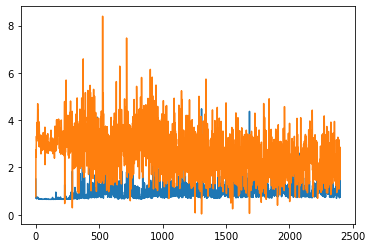

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/
/content
epoch: 0, iter: 0, loss_G: 2.1923084259033203, loss_D: 1.2103636264801025


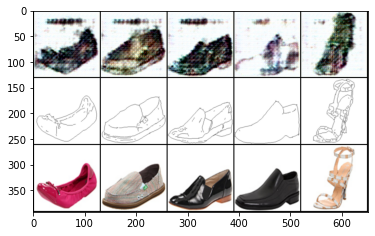

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 0, iter: 50, loss_G: 3.1154985427856445, loss_D: 1.1363567113876343


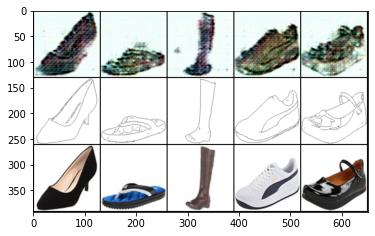

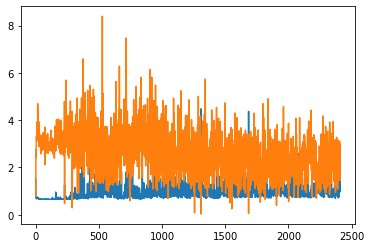

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/
/content
epoch: 0, iter: 100, loss_G: 1.458894968032837, loss_D: 1.0222300291061401


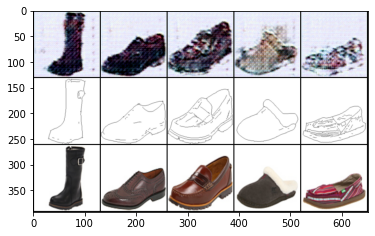

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 0, iter: 150, loss_G: 2.7239584922790527, loss_D: 0.8312294483184814


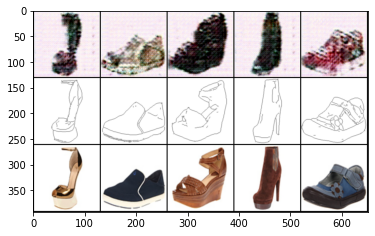

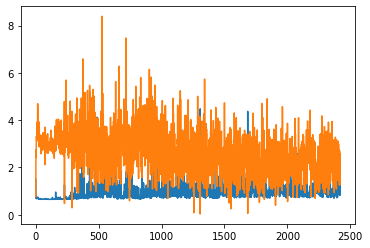

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/
/content
epoch: 0, iter: 200, loss_G: 1.2949182987213135, loss_D: 1.243898630142212


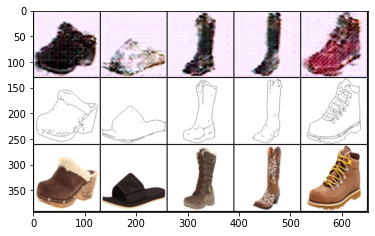

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 0, iter: 250, loss_G: 1.6020560264587402, loss_D: 1.0812543630599976


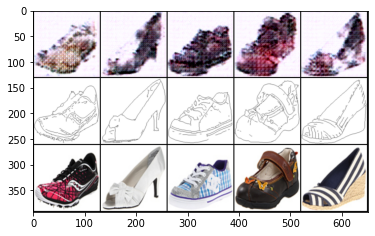

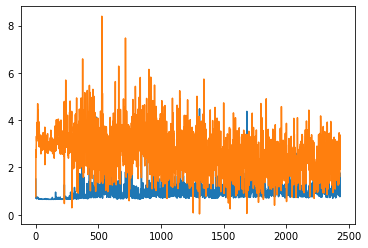

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/
/content
epoch: 0, iter: 300, loss_G: 3.363635301589966, loss_D: 0.9219720363616943


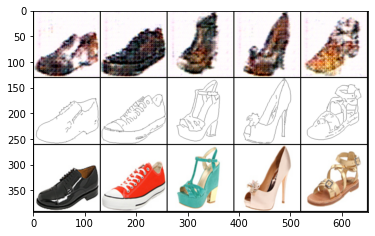

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 0, iter: 350, loss_G: 1.088874340057373, loss_D: 1.4575268030166626


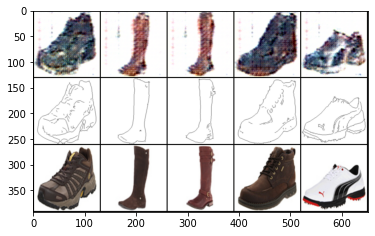

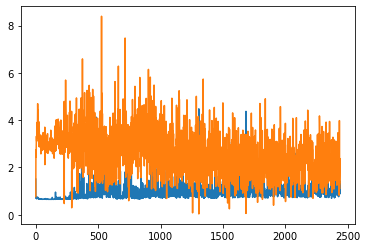

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/
/content
epoch: 0, iter: 400, loss_G: 1.9618104696273804, loss_D: 0.899516761302948


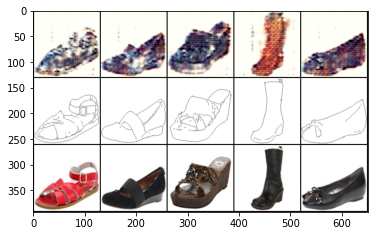

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 0, iter: 450, loss_G: 2.073119640350342, loss_D: 1.2004854679107666


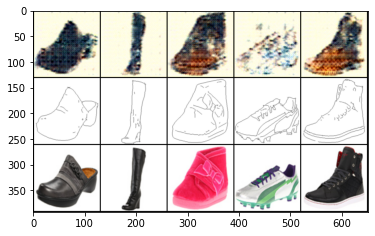

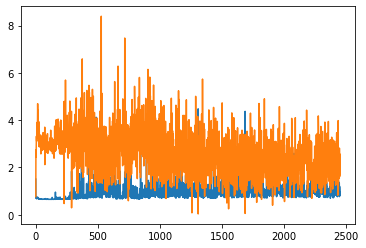

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/
/content
epoch: 0, iter: 500, loss_G: 2.5537428855895996, loss_D: 0.8340668082237244


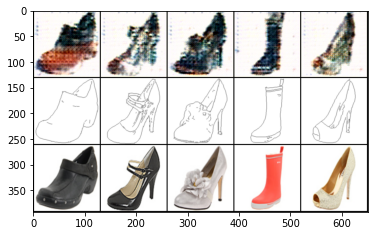

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 0, iter: 550, loss_G: 1.4701426029205322, loss_D: 1.1070886850357056


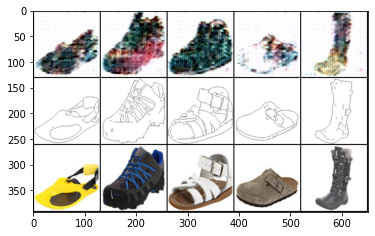

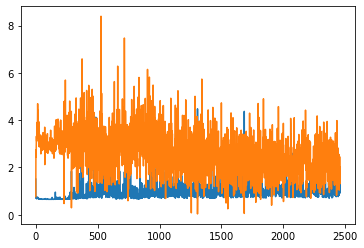

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/
/content
epoch: 0, iter: 600, loss_G: 1.9142860174179077, loss_D: 0.9371956586837769


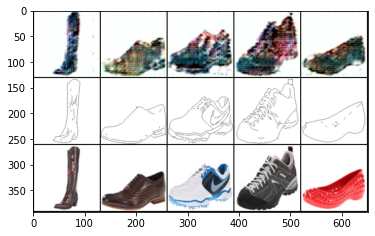

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 0, iter: 650, loss_G: 3.3541579246520996, loss_D: 0.7291073799133301


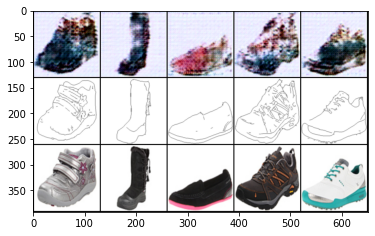

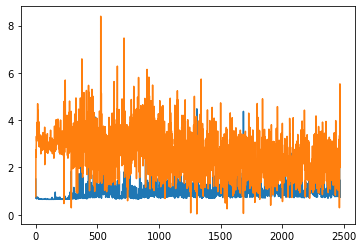

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/
/content
epoch: 0, iter: 700, loss_G: 3.8911807537078857, loss_D: 0.7565488815307617


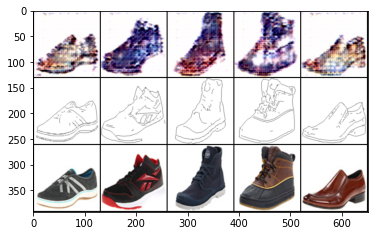

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 0, iter: 750, loss_G: 2.432973623275757, loss_D: 0.8941274881362915


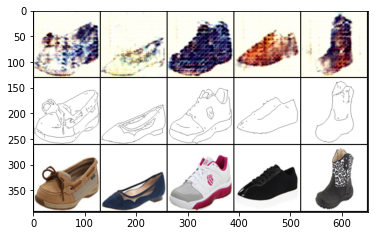

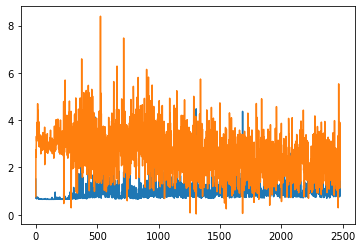

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/
/content
epoch: 0, iter: 800, loss_G: 1.4981154203414917, loss_D: 1.3794152736663818


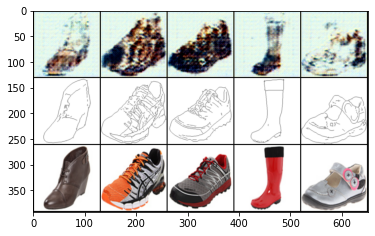

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 0, iter: 850, loss_G: 1.8777291774749756, loss_D: 1.3186798095703125


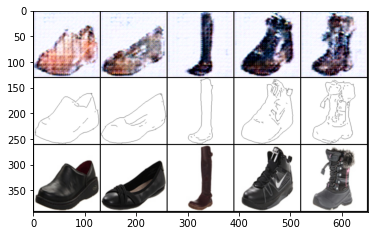

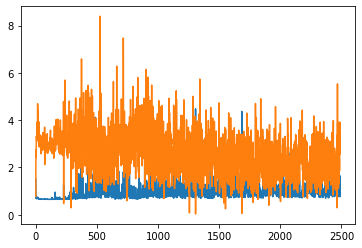

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/
/content
epoch: 0, iter: 900, loss_G: 2.5856549739837646, loss_D: 1.044372320175171


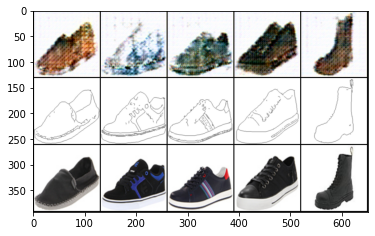

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 0, iter: 950, loss_G: 3.155449867248535, loss_D: 0.8810361623764038


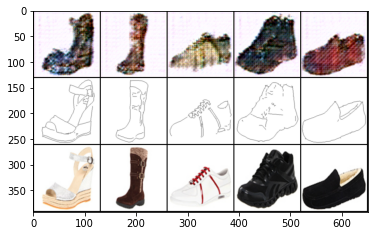

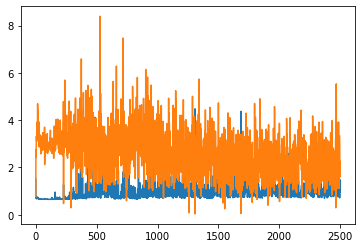

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/
/content
epoch: 0, iter: 1000, loss_G: 1.777255892753601, loss_D: 1.0525085926055908


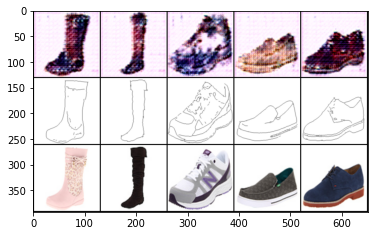

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 0, iter: 1050, loss_G: 1.7013895511627197, loss_D: 1.7208079099655151


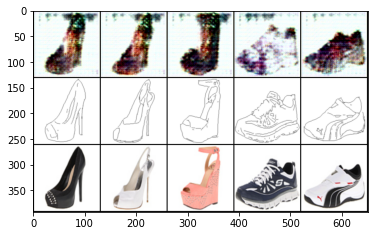

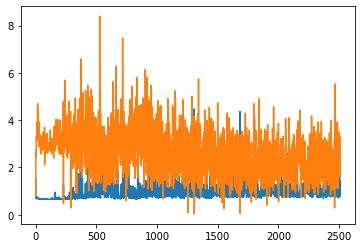

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/
/content
epoch: 0, iter: 1100, loss_G: 1.668580412864685, loss_D: 1.0684341192245483


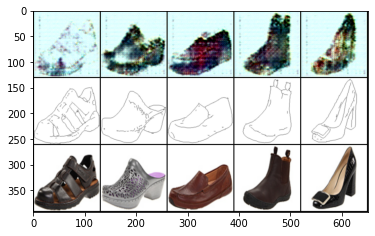

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 0, iter: 1150, loss_G: 1.0569229125976562, loss_D: 1.7417011260986328


In [0]:
#G(x,z), D(x,y)
D.train()
G.train()
for epoch in range(30):
  for i,(x,y) in enumerate(dataloader):
    opt_D.zero_grad()
    opt_G.zero_grad()

    x=x.to(device)
    y=y.to(device)

    #train Discriminator
    #1. for real data
    loss_real=criterion(D(x,y),torch.ones((batch_size,)).to(device)*0.9)

    z=torch.randn((batch_size,1,128,128)).to(device)
    loss_fake=criterion(D(x,G(x,z).detach()),torch.ones((batch_size,)).to(device)*0.1)

    loss_D=loss_real+loss_fake
    loss_D.backward()
    opt_D.step()

    #train Generator
    z=torch.randn((batch_size,1,128,128)).to(device)
    loss_G=criterion(D(x,G(x,z)),torch.ones((batch_size,)).to(device))
    loss_G.backward()
    opt_G.step()


    if i%10==0:
      losses_D.append(loss_D.data)
      losses_G.append(loss_G.data)

    if i%100==0:
      plt.figure()
      plt.plot(losses_D)
      plt.plot(losses_G)
      plt.show()
      
      torch.save(D.state_dict(), "gdrive/My Drive/pix2pixmodel/D.pth")
      torch.save(G.state_dict(), "gdrive/My Drive/pix2pixmodel/G.pth")

    if i%50==0:
      print(f'epoch: {epoch}, iter: {i}, loss_G: {loss_G}, loss_D: {loss_D}')
      generated_imgs=G(x[:5],z[:5])
      real_imgs=x[:5]
      imgs=torch.cat([generated_imgs,real_imgs,y[:5]],0).data.cpu()
      grid=make_grid(imgs,nrow=5).permute(1,2,0).numpy()
      plt.imshow(grid)
      plt.show()
